In [1]:
## Environment Setup

In [2]:
#!pip install folium

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert (0, './_functions_/')
from functions_eda import *

# Business Objectives

Main question: How prepared is Germany for the upcoming EU ban of diesel and petrol cars?

## Datasets

### Number of charging stations in Germany
https://www.kaggle.com/datasets/mexwell/electric-vehicle-charging-in-germany
#### Number of electrical cars in Germany
 - to be used to create ratio of charging station : number of cars
### Zip Code x State
- mainly used to add the state information to the main dataset

In [4]:
df = pd.read_csv('./raw_data/charging_data.csv')
df

,Unnamed: 0,betreiber,art_der_ladeeinrichung,anzahl_ladepunkte,anschlussleistung,steckertypen1,steckertypen2,steckertypen3,steckertypen4,p1_kw,...,p4_kw,kreis_kreisfreie_stadt,ort,postleitzahl,strasse,hausnummer,adresszusatz,inbetriebnahmedatum,breitengrad,laengengrad
0,0,GGEW AG,Normalladeeinrichtung,1,4.6,AC Steckdose Typ 2,NaN,NaN,NaN,4.6,...,NaN,Landkreis Bergstraße,Lorsch,64653,Klosterstr.,23,NaN,2017-01-02,49.653064,8.572109
1,1,Pfalzwerke AG,Schnellladeeinrichtung,2,75.0,AC Steckdose Typ 2,DC Kupplung Combo,NaN,NaN,22.0,...,NaN,Landkreis Bergstraße,Lorsch,64653,Nibelungenstraße,135-137,NaN,2021-04-27,49.652969,8.554764
2,2,ENTEGA Energie GmbH,Normalladeeinrichtung,2,44.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Landkreis Bergstraße,Fürth,64658,Krumbacher Str.,39,NaN,2017-11-21,49.658037,8.787881
3,3,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Landkreis Bergstraße,Fürth,64658,Erbacher Str.,102,a,2022-04-08,49.663670,8.796830
4,4,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Landkreis Bergstraße,Fürth,64658,Schulstr.,12,NaN,2022-04-08,49.646360,8.781410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,36765,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Kreisfreie Stadt Leipzig,Leipzig,4277,Bornaische Straße,108,NaN,2016-06-01,51.301227,12.384566
36766,36766,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Kreisfreie Stadt Leipzig,Leipzig,4277,Scheffelstraße,35,NaN,2016-06-01,51.311695,12.372912
36767,36767,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Kreisfreie Stadt Leipzig,Leipzig,4277,Bornaische Straße,55,NaN,2018-07-05,51.305046,12.382487
36768,36768,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,AC Steckdose Typ 2,AC Steckdose Typ 2,NaN,NaN,22.0,...,NaN,Kreisfreie Stadt Leipzig,Leipzig,4277,Richard Lehmann Straße,120,NaN,2019-08-12,51.314325,12.397213


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36770 entries, 0 to 36769
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              36770 non-null  int64  
 1   betreiber               36770 non-null  object 
 2   art_der_ladeeinrichung  36770 non-null  object 
 3   anzahl_ladepunkte       36770 non-null  int64  
 4   anschlussleistung       36770 non-null  float64
 5   steckertypen1           36770 non-null  object 
 6   steckertypen2           31111 non-null  object 
 7   steckertypen3           2233 non-null   object 
 8   steckertypen4           1132 non-null   object 
 9   p1_kw                   36770 non-null  float64
 10  p2_kw                   31129 non-null  float64
 11  p3_kw                   2233 non-null   float64
 12  p4_kw                   1131 non-null   float64
 13  kreis_kreisfreie_stadt  36770 non-null  object 
 14  ort                     36770 non-null

In [6]:
percentage_null_values(df)

,Percentage_NaN
p4_kw,96.9
steckertypen4,96.9
steckertypen3,93.9
p3_kw,93.9
adresszusatz,87.4
steckertypen2,15.4
p2_kw,15.3
anschlussleistung,0.0
steckertypen1,0.0
art_der_ladeeinrichung,0.0


In [7]:
df.columns

Index(['Unnamed: 0', 'betreiber', 'art_der_ladeeinrichung',
       'anzahl_ladepunkte', 'anschlussleistung', 'steckertypen1',
       'steckertypen2', 'steckertypen3', 'steckertypen4', 'p1_kw', 'p2_kw',
       'p3_kw', 'p4_kw', 'kreis_kreisfreie_stadt', 'ort', 'postleitzahl',
       'strasse', 'hausnummer', 'adresszusatz', 'inbetriebnahmedatum',
       'breitengrad', 'laengengrad'],
      dtype='object')

In [8]:
#remove unnecessary columns. We will not need the streat address for the analysis. The coordinates will be kept, in case we want to plot some map
df = df.drop(columns = ['Unnamed: 0', 'strasse', 'hausnummer', 'adresszusatz', 'p1_kw', 'p2_kw', 'p3_kw', 'p4_kw', 'breitengrad', 'laengengrad', 'steckertypen1',
       'steckertypen2', 'steckertypen3', 'steckertypen4', 'kreis_kreisfreie_stadt'] )


In [9]:
# Rename columns
df = df.rename(columns={
    'betreiber': 'operator',
    'art_der_ladeeinrichung': 'charging_facility_type',
    'anzahl_ladepunkte': 'number_of_charging_points',
    'anschlussleistung': 'power_connection_capacity',
    'ort': 'city',
    'postleitzahl': 'postal_code',
    'inbetriebnahmedatum': 'commissioning_date',   
})

In [10]:
df.columns

Index(['operator', 'charging_facility_type', 'number_of_charging_points',
       'power_connection_capacity', 'city', 'postal_code',
       'commissioning_date'],
      dtype='object')

### Data wrangling

Convert string to datetime

In [11]:
# Convert inbetriebnahmedatum to datetime
df["commissioning_date"] = pd.to_datetime(df["commissioning_date"], errors="coerce")


Extract month and year from commission_date

In [12]:
# Extract year and month
df["year"] = df["commissioning_date"].dt.year
df["month"] = df["commissioning_date"].dt.month

### Read the second dataset

In [13]:
plz_to_bundesland = pd.read_csv('./raw_data/german-postcodes.csv', sep = ';')

plz_to_bundesland.columns
               

Index(['Ort', 'Plz', 'Bundesland'], dtype='object')

In [14]:
plz_to_bundesland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19675 entries, 0 to 19674
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ort         19671 non-null  object 
 1   Plz         19671 non-null  float64
 2   Bundesland  19671 non-null  object 
dtypes: float64(1), object(2)
memory usage: 461.3+ KB


In [15]:
plz_to_bundesland["Plz"] = plz_to_bundesland["Plz"].astype("Int64") 

In [16]:
plz_to_bundesland["Plz"].value_counts()

Plz
14913    75
23936    66
16928    66
19348    62
14715    56
         ..
90513     1
9517      1
37449     1
85604     1
89447     1
Name: count, Length: 8256, dtype: Int64

In [17]:
plz_to_bundesland.drop_duplicates(subset=['Plz'], inplace = True)

#### Add Column Bundesland to the dataset

In [18]:
df = df.merge(plz_to_bundesland, left_on="postal_code", right_on="Plz", how = "left")
df = df.drop(columns=['Plz', 'Ort'])
df

,operator,charging_facility_type,number_of_charging_points,power_connection_capacity,city,postal_code,commissioning_date,year,month,Bundesland
0,GGEW AG,Normalladeeinrichtung,1,4.6,Lorsch,64653,2017-01-02,2017,1,Hessen
1,Pfalzwerke AG,Schnellladeeinrichtung,2,75.0,Lorsch,64653,2021-04-27,2021,4,Hessen
2,ENTEGA Energie GmbH,Normalladeeinrichtung,2,44.0,Fürth,64658,2017-11-21,2017,11,Hessen
3,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,Fürth,64658,2022-04-08,2022,4,Hessen
4,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,Fürth,64658,2022-04-08,2022,4,Hessen
...,...,...,...,...,...,...,...,...,...,...
36765,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2016-06-01,2016,6,Sachsen
36766,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2016-06-01,2016,6,Sachsen
36767,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2018-07-05,2018,7,Sachsen
36768,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2019-08-12,2019,8,Sachsen


In [19]:
percentage_null_values(df)

,Percentage_NaN
Bundesland,1.2
operator,0.0
charging_facility_type,0.0
number_of_charging_points,0.0
city,0.0
power_connection_capacity,0.0
postal_code,0.0
commissioning_date,0.0
year,0.0
month,0.0


### Handling NaNs

Remove NaN from 'Bundesland' 

In [20]:
df.dropna(subset=['Bundesland'])

,operator,charging_facility_type,number_of_charging_points,power_connection_capacity,city,postal_code,commissioning_date,year,month,Bundesland
0,GGEW AG,Normalladeeinrichtung,1,4.6,Lorsch,64653,2017-01-02,2017,1,Hessen
1,Pfalzwerke AG,Schnellladeeinrichtung,2,75.0,Lorsch,64653,2021-04-27,2021,4,Hessen
2,ENTEGA Energie GmbH,Normalladeeinrichtung,2,44.0,Fürth,64658,2017-11-21,2017,11,Hessen
3,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,Fürth,64658,2022-04-08,2022,4,Hessen
4,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,Fürth,64658,2022-04-08,2022,4,Hessen
...,...,...,...,...,...,...,...,...,...,...
36765,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2016-06-01,2016,6,Sachsen
36766,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2016-06-01,2016,6,Sachsen
36767,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2018-07-05,2018,7,Sachsen
36768,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2019-08-12,2019,8,Sachsen


In [21]:
df = df.rename(columns={'Bundesland':'state'})

In [22]:
df.dropna(subset=['state'])

,operator,charging_facility_type,number_of_charging_points,power_connection_capacity,city,postal_code,commissioning_date,year,month,state
0,GGEW AG,Normalladeeinrichtung,1,4.6,Lorsch,64653,2017-01-02,2017,1,Hessen
1,Pfalzwerke AG,Schnellladeeinrichtung,2,75.0,Lorsch,64653,2021-04-27,2021,4,Hessen
2,ENTEGA Energie GmbH,Normalladeeinrichtung,2,44.0,Fürth,64658,2017-11-21,2017,11,Hessen
3,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,Fürth,64658,2022-04-08,2022,4,Hessen
4,Entega Plus GmbH,Normalladeeinrichtung,2,22.0,Fürth,64658,2022-04-08,2022,4,Hessen
...,...,...,...,...,...,...,...,...,...,...
36765,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2016-06-01,2016,6,Sachsen
36766,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2016-06-01,2016,6,Sachsen
36767,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2018-07-05,2018,7,Sachsen
36768,Stadtwerke Leipzig GmbH,Normalladeeinrichtung,2,30.0,Leipzig,4277,2019-08-12,2019,8,Sachsen


In [23]:
df['state'].value_counts()

state
Bayern                    7582
Nordrhein-Westfalen       6599
Baden-Württemberg         6191
Niedersachsen             3617
Hessen                    2757
Sachsen                   1538
Rheinland-Pfalz           1425
Schlewig-Holstein         1364
Berlin                    1258
Hamburg                    933
Brandenburg                783
Thüringen                  670
Sachsen-Anhalt             581
Mecklenburg-Vorpommern     454
Saarland                   308
Bremen                     275
Schleswig-Holstein           2
Name: count, dtype: int64

In [24]:
# correct name of state

In [25]:
df['state'] = df['state'].str.replace("Schlewig-Holstein", "Schleswig-Holstein")

In [26]:
# check again
df['state'].value_counts()


state
Bayern                    7582
Nordrhein-Westfalen       6599
Baden-Württemberg         6191
Niedersachsen             3617
Hessen                    2757
Sachsen                   1538
Rheinland-Pfalz           1425
Schleswig-Holstein        1366
Berlin                    1258
Hamburg                    933
Brandenburg                783
Thüringen                  670
Sachsen-Anhalt             581
Mecklenburg-Vorpommern     454
Saarland                   308
Bremen                     275
Name: count, dtype: int64

In [27]:
df ['charging_facility_type'] = df ['charging_facility_type'].replace('Normalladeeinrichtung', 'Regular') 

In [28]:
df ['charging_facility_type'] = df ['charging_facility_type'].replace('Schnellladeeinrichtung', 'Fast') 

In [29]:
df.to_csv("stations.csv", index = False)

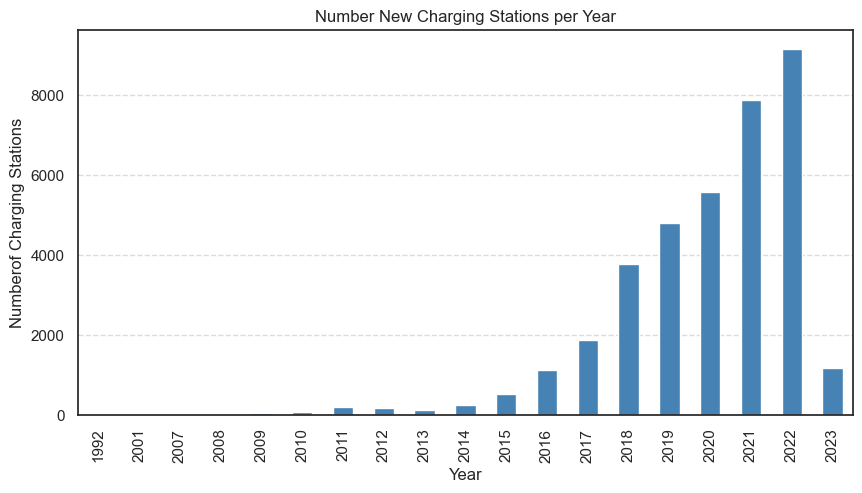

In [30]:
# Plot: Number of stations by year
plt.figure(figsize=(10, 5))
df["year"].value_counts().sort_index().plot(kind="bar", color="steelblue")
plt.title("Number New Charging Stations per Year")
plt.xlabel("Year")
plt.ylabel("Numberof Charging Stations")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [31]:
# drop coluns with YEAR <=2018, to combine with the other datasets

# Drop rows where the year is <= 2018
df_filtered = df[df["year"] > 2017]

# Save the filtered dataset
filtered_file_path = "./clean_data/charging_data.csv"
df_filtered.to_csv(filtered_file_path, index=False)

filtered_file_path

'./clean_data/charging_data.csv'

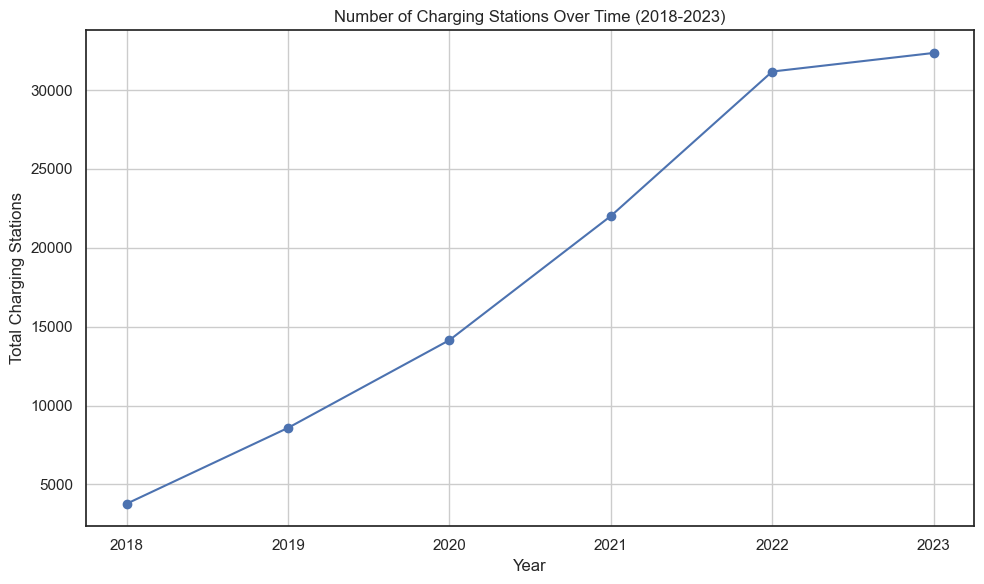

In [32]:
# Count how many stations were commissioned each year
yearly_counts = df_filtered.groupby("year").size().sort_index()

# Accumulate the counts
cumulative_counts = yearly_counts.cumsum()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_counts.index, cumulative_counts.values, marker='o')
plt.title("Number of Charging Stations Over Time (2018-2023)")
plt.xlabel("Year")
plt.ylabel("Total Charging Stations")
plt.grid(True)
plt.tight_layout()
plt.show()


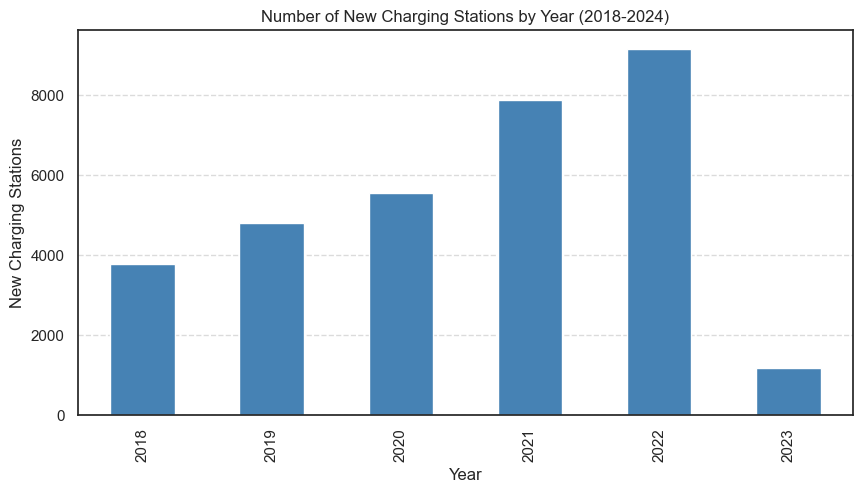

In [33]:
df = df_filtered

# Plot: Number of stations by year
plt.figure(figsize=(10, 5))
df["year"].value_counts().sort_index().plot(kind="bar", color="steelblue")
plt.title("Number of New Charging Stations by Year (2018-2024)")
plt.xlabel("Year")
plt.ylabel("New Charging Stations")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


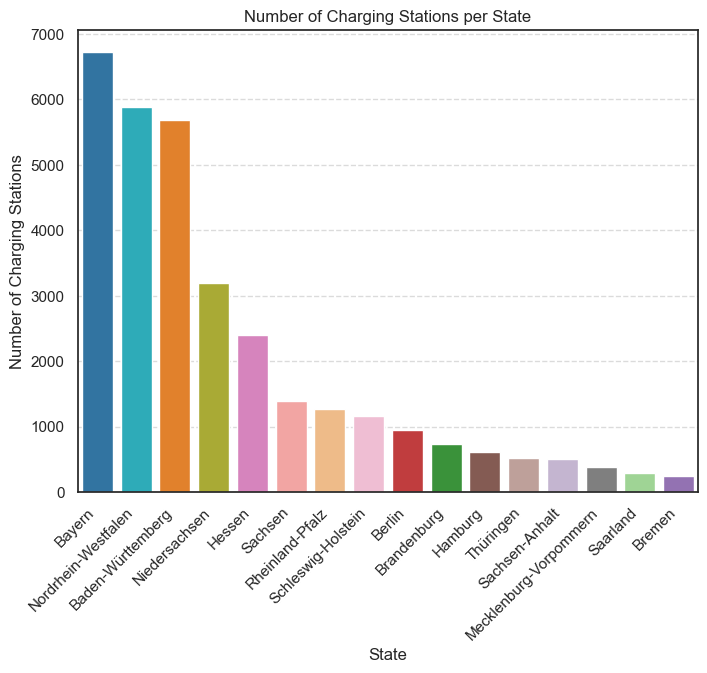

In [37]:
# Count the number of stations per state
stations_by_state = df["state"].value_counts().reset_index()
stations_by_state.columns = ["state", "count"]

# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(data=stations_by_state, x="state", y="count", palette=german_states_colors)

plt.title("Number of Charging Stations per State")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations")

plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Create a Summary Dataframe

Groups number of charging stations, number of charging points, number of fast charging stations, number of regular charging stations per state

In [38]:
# Calculate the fields
df["is_fast"] = df["charging_facility_type"] == "Fast"
df["is_regular"] = df["charging_facility_type"] == "Regular"

# Create the summary DataFrame
df_stations_per_state = df.groupby("state").agg(
    number_of_charging_points=("number_of_charging_points", "sum"),
    number_of_stations=("operator", "count"),
    number_fast_charging_stations=("is_fast", "sum"),
    number_regular_charging_stations=("is_regular", "sum")
).reset_index()


df_stations_per_state.head()


,state,number_of_charging_points,number_of_stations,number_fast_charging_stations,number_regular_charging_stations
0,Baden-Württemberg,11419,5678,842,4836
1,Bayern,12367,6722,873,5849
2,Berlin,1641,954,144,810
3,Brandenburg,1440,737,152,585
4,Bremen,516,247,31,216


In [39]:
df_stations_per_state.to_csv('./clean_data/stations_per_state.csv', index=False)